# Richter's Predictor: Modeling Earthquake Damage

## Step 0: Initial Tasks
In this Google Colab Notebook we will be applying the basic algorithm seen in class so that we can actually start figuring a potential baseline for the final project.

Let's start by importing all the necessary Python libraries.

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Now, we have to download the data. To do so, we will use the next downloading method.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_values.csv
df_train_values = pd.read_csv('train_values.csv', index_col='building_id')
df_train_values.shape

--2022-12-17 10:09:34--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_values.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_values.csv [following]
--2022-12-17 10:09:34--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23442727 (22M) [text/plain]
Saving to: ‘train_values.csv’

train_values.csv    100%[===================>]  22.36M  --.-KB/s    in 0.06s   

2022-12-17 10:09:36 (401 MB/s) - ‘train_values.csv’ saved [2344

(260601, 38)

As we can see, we have 38 features and a total of 260601 registers, i.e., 260601 buildings that have been analysed so that we can train our model.

But, we also need the training labels, since this training dataset comes without the labels, so let's download it too.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_labels.csv
df_train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
df_train_labels.head()

--2022-12-17 10:09:37--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_labels.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_labels.csv [following]
--2022-12-17 10:09:38--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2330792 (2.2M) [text/plain]
Saving to: ‘train_labels.csv’

train_labels.csv    100%[===================>]   2.22M  --.-KB/s    in 0.008s  

2022-12-17 10:09:38 (263 MB/s) - ‘train_labels.csv’ saved [2330

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


Is important to remember that the label `damage_grade` is the ordinal variable which represents the level of damage to the building that was hit by the earthquake. This variable can take 3 different values:
- 1: Low level damage.
- 2: medium amount of damage.
- 3: almost complete destruction.

The idea of the project is to be able to predict the amount of damage that a building will suffer according to parameters like these ones:

In [ ]:
df_train_values.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
     

For a more deeper description of each variable, check the competition [link](https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/).

The next step for the first stage, is to merge the train_values with the train_labels, so that we can work with a unified dataset. To do so:

In [ ]:
df_train_values.join(df_train_labels).to_csv('train_full.csv')

By this way, we have stored a full dataset with all the registers joined with the labels in a local file called `train_full.csv`.

## Step 1: Exploratory Data Analysis
It is always usefull to make a prior statistical exploratory analysis over the data so that we can increase the knowledge over it for further interpretations.

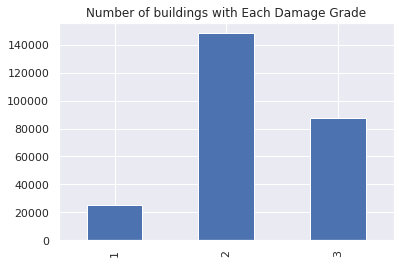

In [ ]:
(df_train_labels.damage_grade
  .value_counts()
  .sort_index()
  .plot.bar(title='Number of buildings with Each Damage Grade'))

As we can see, the most frequent house damage is a medium level, followed by the complete destruction and, finally, by the low level damage.

It also might be usefull to check some of the firsts registers of the dataset to try to understand better some features:

In [ ]:
df_train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


## Step 2: Feature Selection / Feature Engineering
Now it's time to try to make an initial selection of the variables so that we can work with a reduced amount of variables.

It is important to highlight that this feature engineering is **not** the final one, we still have to work on it to refine, but to make the first steps, will be enough.

To do this, we might want to perform a correlation study, so that we can try to remove redundancy.

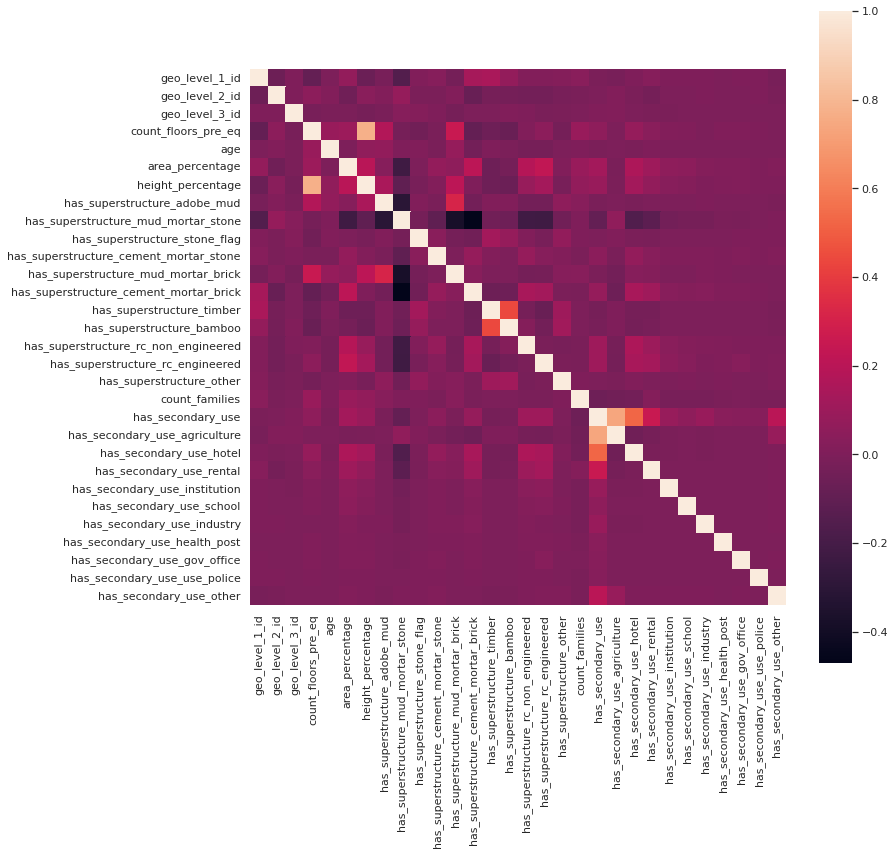

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train_values.corr(), square=True)

The final selected features lists will be:

In [ ]:
selected = ['count_floors_pre_eq', 'age', 'ground_floor_type','has_secondary_use', 'land_surface_condition', 'roof_type', 
            'foundation_type', 'height_percentage','has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
            'has_superstructure_stone_flag','has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
            'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 
            'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other']
df_train_select = df_train_values[selected]
df_train_select.shape

(260601, 19)

We have selected a total of 18 features.

In [ ]:
%%script echo skipping
sns.pairplot(df_train_select)

skipping


### Categorial Label Encoding
It is necessary to encode the categorical values into numerical ones, to do so, we will use the OneHotEncoder and its method `get_dummies()`. Leading to the following code cell.

In [ ]:
df_train_select = pd.get_dummies(df_train_select)
df_train_select.head()

,count_floors_pre_eq,age,has_secondary_use,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,land_surface_condition_o,land_surface_condition_t,roof_type_n,roof_type_q,roof_type_x,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w
building_id,,,,,,,,,,,,,,,,,,,,,
802906,2,30,0,5,1,1,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
28830,2,10,0,7,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
94947,2,10,0,5,0,1,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
590882,2,10,0,5,0,1,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
201944,3,30,0,9,1,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0


### Split the Dataset
Now it's turn to split the dataset in different parts in order to further validations techniques to be applied correctly.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_train_select, df_train_labels.damage_grade, random_state=1)

## Step 3: Baseline Estimation
Once we have preprocessed the data and selected the relevant (a priori) features, we can now start applying some basic Supervised Learning algorithms.

### Naive Bayes
The first algorithm to apply will be Naive Bayes. This algorithm is based on the Bayes' conditioned probability formula. The inner steps of this algorithm were:
1. Calculate the a posteriori probability $P(C|A_{1}, A_{2}, ..., A_{n})$ for all the values of $C$ using Bayes's theorem. This step can be considered the **training step** of this algorithm.
2. Obtain the value of $C$ that maximizes $P(C|A_{1}, A_{2}, ..., A_{n})$.
3. Equivalent to obtaining the value of $C$ that maximizes $P(A_{1}, A_{2}, ..., A_{n}|C)P(C)$.
  - To calculate this probability, we can use this secondary formula: $P(A_{1}, A_{2}, ..., A_{n}|C) = P(A_{1}|C)P(A_{2}|C)...P(A_{n}|C)$.

Once we have seen a quick theoretical resume, we have to take some considerations:
- We have to choose an implementation model according to the predicted variable (_damage_grade_). Since we are talking about a categorical variable which can take 3 values, we will use the **ComplementNB model**.

In [ ]:
dtype(x_train)

NameError: ignored

In [ ]:
from sklearn.naive_bayes import ComplementNB
nb_model = ComplementNB()
nb_model.fit(x_train, y_train)
y_model = nb_model.predict(x_test)

Now, in order to check the performance of the algorithm, let's check the F1 score and the confusion matrix.

In [ ]:
f1_sc = f1_score(y_test, y_model, average='micro')
print(f'F1 Score Result: {f1_sc}')
print(classification_report(y_test, y_model, labels=nb_model.classes_))

F1 Score Result: 0.4016668969010453
              precision    recall  f1-score   support

           1       0.26      0.72      0.38      6238
           2       0.64      0.15      0.25     37210
           3       0.41      0.74      0.53     21703

    accuracy                           0.40     65151
   macro avg       0.44      0.54      0.38     65151
weighted avg       0.53      0.40      0.35     65151



As we can see in a first view, our model has a quite low value for the F1 score, what means that we need to improve our model in further improvements of the baseline.

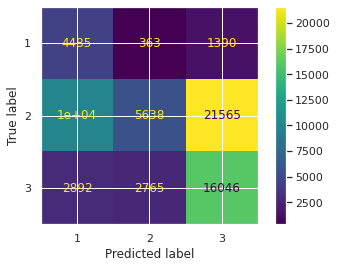

In [ ]:
cm = confusion_matrix(y_test, y_model, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot()

As we can check in the confusion matrix, there are a lot of misclassification with the 2nd class that should be classified as the 3rd class of damage.

It is important to highlight that, from the obtained calification of the F1-Score over the Naive Bayes algorithm, several executions where performed in order to maximize the accuracy. Check this [link](https://drive.google.com/file/d/1tGNe3ZXj4juQeUNVQtejEX-mkDONKMir/view?usp=sharing) for more details.

#### Submission
The obtained score was $F_{micro}=0.5802$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_NaiveBayes.csv` section.

### kNN Algorithm
This algorithm mainly consists on taking a classification decission (although this algorithm can also be applied on regression) based on the $k$ nearest neighbors and some other metrics regarding this decission, which we will be checking below.

First of all, we will be working initially with the last feature selection done aiming to maximize the score of the Naive Bayes results, but we will also try with other feature selection.

In [ ]:
df_train_values = pd.read_csv('train_values.csv', index_col='building_id')

df_train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

df_full = df_train_values.join(df_train_labels)
df_full.shape

(260601, 39)

The next step corresponds to the previously mentioned feature selection.

In [ ]:
selected = ['count_floors_pre_eq', 'age', 'ground_floor_type','has_secondary_use', 'land_surface_condition', 'roof_type', 
            'foundation_type', 'height_percentage','has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
            'has_superstructure_stone_flag','has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
            'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 
            'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other',
            'damage_grade'] # This last one corresponds to the goal label 

df_full_select = df_full[selected]

Now it's turn to encode the categorical variables in order to avoid problems with the algorithm.

In [ ]:
df_ready = pd.get_dummies(df_full_select)

The final step in the preprocessing is dividing the dataset for training and testing according to the selected values. To do so:

In [ ]:
train, test = train_test_split(df_ready, test_size=0.33)
train.reset_index(inplace = False)
test.reset_index(inplace = False)
train.columns

Index(['count_floors_pre_eq', 'age', 'has_secondary_use', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'damage_grade', 'ground_floor_type_f', 'ground_floor_type_m',
       'ground_floor_type_v', 'ground_floor_type_x', 'ground_floor_type_z',
       'land_surface_condition_n', 'land_surface_condition_o',
       'land_surface_condition_t', 'roof_type_n', 'roof_type_q', 'roof_type_x',
       'foundation_type_h', 'foundation_type_i', 'foundation_type_r',
       'foundation_type_u', 'foundation_type_w'],
      dtype='object')

#### Parametrization
Before applying the algorithm itself, we have to set some parameters as we explained at the begining of this algorithm.
- **kNeighborsClassifier**: It is based on the number of neightbors of each query point.
- **Weights**: Remember that one of the voting techniques for the classification for this algorithm was by mean of weights. In scikit learn we can do this with two types of weights:
    - uniform weights: each point in the neighborhood contributes uniformly in the classification of a query point.
    - distance weights: points nearer to the query point will have more importance when deciding.

It is important to highlight the use of **Cross Validation** in order to get the best value of $k$, and so, choose the best model.

So, the code for the cross validation will be:

In [ ]:
%%script echo skipping
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#### PREVIOUSLY IMPORTED ####
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import f1_score

cv = KFold(n_splits = 5, shuffle = True)
k_value = [128]

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in k_value: # 
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric='minkowski', p=1)
       for train_fold, test_fold in cv.split(train):
          # Random train & test division
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # Model Training & Execution
          knn.fit( X = f_train.drop(['damage_grade'], axis=1),
                               y = f_train['damage_grade'])
          y_pred = knn.predict(X = f_test.drop(['damage_grade'], axis = 1))
          # Model Evaluation
          acc = f1_score(f_test['damage_grade'], y_pred, average='micro')
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')      
    

plt.legend()
plt.show() 

skipping


#### Executing the Algorithm
Now it's time to execute the algorithm, the first step is, taking into account the number of neighbors from the previous step, $n\_neighbors = 128$

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
# constructor
n_neighbors = 128
weights = 'distance'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights, metric='minkowski', p=1) 
# fit and predict
knn.fit(X = train.drop(['damage_grade'], axis=1), y = train['damage_grade'])
y_pred = knn.predict(X = test.drop(['damage_grade'], axis=1))
acc = f1_score(test['damage_grade'], y_pred, average='micro')
print ('Acc', acc)

Acc 0.584785869603135


#### Visualization
we could also visualize the results with a Voronoi graph, but due to its time consuming requirement, we don't consider it representative enough, so we will let the code but skipping its execution.

In [ ]:
%%script echo skipping
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .05  # step size in the mesh



X = train.values
y = train['damage_grade'].values

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
             edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

skipping


Then, we will plot its conffusion matrix so that we can at least understand in a deeper way its accuracy.

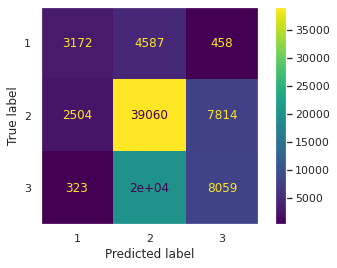

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test['damage_grade'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

As we see, we can highlight how it misbehaves with second category. This might be due to the unbalanced distribution of the data. This issue should be considered on the future.

#### Submission
Let's now try to submit the results to the plaform and check the accuracy on the plaform with kNN algorithm. So we have to prepare the submission data.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected[:-1]]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-02 12:38:45--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-02 12:38:46--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv.2’

test_values.csv.2   100%[===================>]   7.45M  --.-KB/s    in 0.09s   

2022-12-02 12:38:46 (83.2 MB/s) - ‘test_values.csv.2’ saved [7815385/

In [ ]:
test_values_subset

,building_id,count_floors_pre_eq,age,has_secondary_use,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,land_surface_condition_o,land_surface_condition_t,roof_type_n,roof_type_q,roof_type_x,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w
0,38657,2,20,0,4,0,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0
1,893061,3,25,0,7,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
2,365826,2,0,0,5,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,786818,3,40,0,7,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
4,496332,2,5,0,6,0,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174597,893601,2,20,0,4,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
174598,697025,1,10,0,3,0,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0
174599,406394,2,20,0,4,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
174600,892872,2,50,0,7,0,1,0,0,0,...,0,1,1,0,0,0,0,1,0,0


In [ ]:
predictions = knn.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_knn = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_knn.head()

--2022-12-02 13:21:01--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-02 13:21:01--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.04s   

2022-12-02 13:21:01 (16.8 MB/s) - ‘submission_fo

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission_knn.to_csv('submission_knn.csv')

The obtained score was $F_{micro} = 0.5802$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_knn.csv` section.

### Decision Trees

First of all, we get all the training dataframes that we are going to use in the Decision Trees, as well as store the selected features that we will be using.

In [ ]:
df_train_values = pd.read_csv('train_values.csv', index_col='building_id')
df_train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
df_full = df_train_values.join(df_train_labels)
df_full.shape

(260601, 39)

In [ ]:
selected = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other',
       'damage_grade'] # This last one corresponds to the goal label 

df_full_select = df_full[selected]

Since variables like `position` or `foundation_type` are categorical variables, we need to create for each of them new variables called dummies that represent each possible value that they could store.

In [ ]:
df_ready = pd.get_dummies(df_full_select)

In [ ]:
train, test = train_test_split(df_ready, test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
df_ready.reset_index(inplace = True)

In [ ]:
df_ready.groupby('damage_grade').size()

damage_grade
1     25124
2    148259
3     87218
dtype: int64

#### Tuning

We need to optimize some parameters of the DecisionTree, in this example the max_depth. For this purpose, we will use KFold validation. we split the dataset into train and class in a linear way (because the time dimension)

Others parameters:

criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
min_samples_split: The minimum number of samples required to split an internal node
min_samples_leaf: The minimum number of samples required to be at a leaf node (smoothing effecgt in regression)
class_weight: Weights associated with classes in the form. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data

In [ ]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(df_ready))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             max_depth = depth,
                                             class_weight='balanced'
                                            )
    for train_fold, test_fold in cv.split(df_ready):
        f_train = df_ready.loc[train_fold]
        f_test = df_ready.loc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['damage_grade'], axis=1), 
                               y = f_train['damage_grade'])
        y_pred = tree_model.predict(X = f_test.drop(['damage_grade'], axis = 1))
        test_acc = f1_score(f_test['damage_grade'], y_pred, average='micro')
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

KeyboardInterrupt: ignored

In [ ]:
max(accuracies)
index = accuracies.index(max(accuracies))
print(depth_range[index])

29


So, for this iteration, the maximum depth of the Decision Tree will be 29.

#### Execution

We get the dataframe with the selected features ready with the dummies variables, as well as the training sets with all the features `damage_grade`.

In [ ]:
df_ready = pd.get_dummies(df_full_select)
excluded_index = np.where(df_ready.columns.values == 'damage_grade')[0].item(0)
features = np.concatenate([df_ready.columns.values[:excluded_index],df_ready.columns.values[excluded_index+1:]])
x_train = train[features]
y_train = train['damage_grade']
x_test = test[features]

And now, we train the model.

In [ ]:
from sklearn import tree

#Constructor/Parametrization
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 25, 
                                  class_weight='balanced')
# fit: training the model
clf.fit(x_train, y_train) # Construcción del modelo

# prediction/test
preds = clf.predict(x_test) 

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.metrics import classification_report
print("Metrics \n" 
      +classification_report(y_true=test['damage_grade'], y_pred=preds))

# Confussion Matrix
print("Confussion Matrix:\n")
matriz = pd.crosstab(test['damage_grade'], preds, rownames=['actual'], colnames=['preds'])
print(matriz)

print(pd.DataFrame({'Feature': features ,
              'Importance': clf.feature_importances_}),"\n")

Metrics 
              precision    recall  f1-score   support

           1       0.45      0.57      0.50      8196
           2       0.73      0.64      0.68     49003
           3       0.59      0.68      0.63     28800

    accuracy                           0.64     85999
   macro avg       0.59      0.63      0.61     85999
weighted avg       0.66      0.64      0.65     85999

Confussion Matrix:

preds      1      2      3
actual                    
1       4635   3018    543
2       4974  31289  12740
3        710   8586  19504
                                   Feature  Importance
0                           geo_level_1_id    0.188085
1                           geo_level_2_id    0.110745
2                           geo_level_3_id    0.114086
3                      count_floors_pre_eq    0.010722
4                                      age    0.078650
5                          area_percentage    0.083602
6                        height_percentage    0.042499
7             h

It is important to highlight that, thanks to these results, which orders us the features according to is importance rate, we consider appropiate to make another iteration and execute both, kNN and Decision Trees but taking those variables as the feautre selection result.

#### Visualization

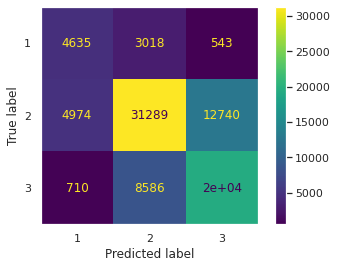

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test['damage_grade'], y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

We can see that the main source of mistakes comes from labeling the first and third group as the second. This is normal, since the data is unbalanced. However, for the third label's case, it is concerning that the ammount of mistakes is higher than the half of the hits.

In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

^C


In [ ]:
from IPython.display import Image

from io import StringIO

dot_data = StringIO()
#tree.export_graphviz(clf, out_file=dot_data, feature_names=list(df_ready_full.drop(['CLASIFICADOR'], axis=1)))
tree.export_graphviz(clf, out_file = dot_data, proportion = True,
                     feature_names=list(df_ready.drop(['damage_grade'], axis=1)), 
                     class_names = ['1','2','3'], rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

KeyboardInterrupt: ignored

#### Submission

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected[:-1]]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-03 15:55:28--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-03 15:55:29--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv.2’

test_values.csv.2   100%[===================>]   7.45M  --.-KB/s    in 0.09s   

2022-12-03 15:55:29 (81.2 MB/s) - ‘test_values.csv.2’ saved [7815385/

In [ ]:
predictions = clf.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_dt = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_dt.head()

--2022-12-03 15:55:31--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-03 15:55:31--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv.2’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.05s   

2022-12-03 15:55:32 (16.5 MB/s) - ‘submission_

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [ ]:
my_submission_dt.to_csv('submission_dt.csv')

### kNN Algorithm (Second Iteration)
In this iteration we will try againg the kNN process but with a reduced number of variables, according to the results of the Decision Trees.

In [ ]:
df_train_values = pd.read_csv('train_values.csv', index_col='building_id')

df_train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

df_full = df_train_values.join(df_train_labels)
df_full.shape

(260601, 39)

The next step corresponds to the previously mentioned feature selection.

In [ ]:
selected = ['geo_level_1_id', 'foundation_type', 'geo_level_2_id', 'has_superstructure_mud_mortar_stone', 'age', 'geo_level_3_id', 
            'damage_grade'] # This last one corresponds to the goal label 

df_full_select = df_full[selected]

Now it's turn to encode the categorical variables in order to avoid problems with the algorithm.

In [ ]:
df_ready = pd.get_dummies(df_full_select)

The final step in the preprocessing is dividing the dataset for training and testing according to the selected values. To do so:

In [ ]:
train, test = train_test_split(df_ready, test_size=0.33)
train.reset_index(inplace = False)
test.reset_index(inplace = False)
train.columns

Index(['geo_level_1_id', 'geo_level_2_id',
       'has_superstructure_mud_mortar_stone', 'age', 'geo_level_3_id',
       'damage_grade', 'foundation_type_h', 'foundation_type_i',
       'foundation_type_r', 'foundation_type_u', 'foundation_type_w'],
      dtype='object')

#### Parametrization
Before applying the algorithm itself, we have to set some parameters as we explained at the begining of this algorithm.
- **kNeighborsClassifier**: It is based on the number of neightbors of each query point.
- **Weights**: Remember that one of the voting techniques for the classification for this algorithm was by mean of weights. In scikit learn we can do this with two types of weights:
    - uniform weights: each point in the neighborhood contributes uniformly in the classification of a query point.
    - distance weights: points nearer to the query point will have more importance when deciding.

It is important to highlight the use of **Cross Validation** in order to get the best value of $k$, and so, choose the best model.

So, the code for the cross validation will be:

In [ ]:
%%script echo skipping
## DA ERROR PERO NO ENTIENDO PORQUE ##
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#### PREVIOUSLY IMPORTED ####
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import f1_score

cv = KFold(n_splits = 5, shuffle = True)
k_value = [16,32,64,96]

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in k_value: # 
       fold_accuracy = []
       knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, metric='minkowski', p=1)
       for train_fold, test_fold in cv.split(train):
          # Random train & test division
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # Model Training & Execution
          knn.fit( X = f_train.drop(['damage_grade'], axis=1),
                               y = f_train['damage_grade'])
          y_pred = knn.predict(X = f_test.drop(['damage_grade'], axis = 1))
          # Model Evaluation
          acc = f1_score(f_test['damage_grade'], y_pred, average='micro')
          fold_accuracy.append(acc)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Max Value ' +  weights + " : " +  str(max(total_scores)) +" (" + str(np.argmax(total_scores) + 1) + ")")
   plt.ylabel('Acc')      
    

plt.legend()
plt.show() 

skipping


#### Executing the Algorithm
Now it's time to execute the algorithm, the first step is, taking into account the number of neighbors from the previous step, $n\_neighbors = 16$

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
# constructor
n_neighbors = 16
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights, metric='minkowski', p=1) 
# fit and predict
knn.fit(X = train.drop(['damage_grade'], axis=1), y = train['damage_grade'])
y_pred = knn.predict(X = test.drop(['damage_grade'], axis=1))
acc = f1_score(test['damage_grade'], y_pred, average='micro')
print ('Acc', acc)

Acc 0.7057058803009337


#### Visualization
we could also visualize the results with a Voronoi graph, but due to its time consuming requirement, we don't consider it representative enough, so we will let the code but skipping its execution.

In [ ]:
%%script echo skipping
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
h = .05  # step size in the mesh



X = train.values
y = train['damage_grade'].values

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
             edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

skipping


Then, we will plot its conffusion matrix so that we can at least understand in a deeper way its accuracy.

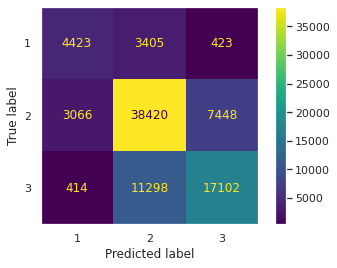

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test['damage_grade'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

If we take a look to the confusion matrix, we can understand two things:
- There is a considerable misclassification between prediction for label 2 and current label 3 and viceversa.
- There is also a few mistakes between prediction for label 1 and current label 2 and viceversa.
- But, at least, it does almost misclassifies between label 1 and 3, which is not a bad thing, considering they are completely opposite labels.

#### Submission
Let's now try to submit the results to the plaform and check the accuracy on the plaform with kNN algorithm. So we have to prepare the submission data.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected[:-1]]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-06 09:44:39--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-06 09:44:39--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  --.-KB/s    in 0.03s   

2022-12-06 09:44:40 (288 MB/s) - ‘test_values.csv’ saved [7815385/7

In [ ]:
test_values_subset

,geo_level_1_id,geo_level_2_id,has_superstructure_mud_mortar_stone,age,geo_level_3_id,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w
building_id,,,,,,,,,,
300051,17,596,1,20,11307,0,0,1,0,0
99355,6,141,1,25,11987,0,0,1,0,0
890251,22,19,1,5,10044,0,0,1,0,0
745817,26,39,0,0,633,0,0,1,0,0
421793,17,289,1,15,7970,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
310028,4,605,1,70,3623,0,0,1,0,0
663567,10,1407,1,25,11907,0,0,1,0,0
1049160,22,1136,1,50,7712,0,0,1,0,0


In [ ]:
predictions = knn.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_knn_iter2 = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_knn_iter2.head()

--2022-12-06 09:44:50--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-06 09:44:51--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.005s  

2022-12-06 09:44:51 (151 MB/s) - ‘submission

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,2


In [ ]:
my_submission_knn_iter2.to_csv('submission_knn.csv')

The obtained score was $F_{micro} = 0.6938$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_knn_iter2.csv` section.

### Decision Trees (Second Iteration)

In this iteration we will try again constructing a Decision Tree model but with a reduced number of variables, according to the results of the previous Decision Tree.

In [ ]:
df_train_values = pd.read_csv('train_values.csv', index_col='building_id')
df_train_labels = pd.read_csv('train_labels.csv', index_col='building_id')
df_full = df_train_values.join(df_train_labels)
df_full.shape

(260601, 39)

In [ ]:
selected = ['geo_level_1_id', 'foundation_type', 'geo_level_2_id', 'has_superstructure_mud_mortar_stone', 'age', 'geo_level_3_id', 
            'damage_grade'] # This last one corresponds to the goal label 

df_full_select = df_full[selected]

In [ ]:
df_ready = pd.get_dummies(df_full_select)

In [ ]:
train, test = train_test_split(df_ready, test_size=0.33)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
df_ready.reset_index(inplace = True)

In [ ]:
df_ready.groupby('damage_grade').size()

damage_grade
1     25124
2    148259
3     87218
dtype: int64

#### Tuning

We need to optimize some parameters of the DecisionTree, in this example the max_depth. For this purpose, we will use KFold validation. we split the dataset into train and class in a linear way (because the time dimension)

Others parameters:

criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
min_samples_split: The minimum number of samples required to split an internal node
min_samples_leaf: The minimum number of samples required to be at a leaf node (smoothing effecgt in regression)
class_weight: Weights associated with classes in the form. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data

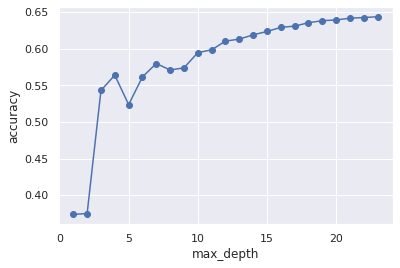

In [ ]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(df_ready))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             max_depth = depth,
                                             class_weight='balanced'
                                            )
    for train_fold, test_fold in cv.split(df_ready):
        f_train = df_ready.loc[train_fold]
        f_test = df_ready.loc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['damage_grade'], axis=1), 
                               y = f_train['damage_grade'])
        y_pred = tree_model.predict(X = f_test.drop(['damage_grade'], axis = 1))
        test_acc = f1_score(f_test['damage_grade'], y_pred, average='micro')
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [ ]:
max(accuracies)
index = accuracies.index(max(accuracies))
print(depth_range[index])

23


#### Execution

In [ ]:
df_ready = pd.get_dummies(df_full_select)
excluded_index = np.where(df_ready.columns.values == 'damage_grade')[0].item(0)
features = np.concatenate([df_ready.columns.values[:excluded_index],df_ready.columns.values[excluded_index+1:]])
x_train = train[features]
y_train = train['damage_grade']
x_test = test[features]

In [ ]:
from sklearn import tree

#Constructor/Parametrization
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 23, 
                                  class_weight='balanced')
# fit: training the model
clf.fit(x_train, y_train) # Construcción del modelo

# prediction/test
preds = clf.predict(x_test) 

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.metrics import classification_report
print("Metrics \n" 
      +classification_report(y_true=test['damage_grade'], y_pred=preds))

# Confussion Matrix
print("Confussion Matrix:\n")
matriz = pd.crosstab(test['damage_grade'], preds, rownames=['actual'], colnames=['preds'])
print(matriz)

print(pd.DataFrame({'Feature': features ,
              'Importance': clf.feature_importances_}),"\n")

Metrics 
              precision    recall  f1-score   support

           1       0.43      0.71      0.54      8240
           2       0.75      0.62      0.68     48786
           3       0.62      0.69      0.65     28973

    accuracy                           0.65     85999
   macro avg       0.60      0.67      0.62     85999
weighted avg       0.68      0.65      0.66     85999

Confussion Matrix:

preds      1      2      3
actual                    
1       5827   2026    387
2       6578  30115  12093
3       1043   7845  20085
                               Feature  Importance
0                       geo_level_1_id    0.230469
1                       geo_level_2_id    0.179374
2  has_superstructure_mud_mortar_stone    0.040738
3                                  age    0.139768
4                       geo_level_3_id    0.223851
5                    foundation_type_h    0.002406
6                    foundation_type_i    0.005891
7                    foundation_type_r    0.173

#### Visualization

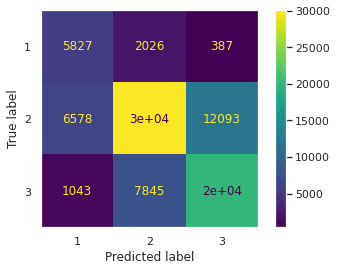

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test['damage_grade'], y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

Compared to the first iteration, the most notorious change is that it is labeling more data as the first label, reducing the ammount of second and third labels.

In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [ ]:
from IPython.display import Image

from io import StringIO

dot_data = StringIO()
#tree.export_graphviz(clf, out_file=dot_data, feature_names=list(df_ready_full.drop(['CLASIFICADOR'], axis=1)))
tree.export_graphviz(clf, out_file = dot_data, proportion = True,
                     feature_names=list(df_ready.drop(['damage_grade'], axis=1)), 
                     class_names = ['1','2','3'], rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

KeyboardInterrupt: ignored

#### Submission

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected[:-1]]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-03 15:48:39--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-03 15:48:40--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv.1’

test_values.csv.1   100%[===================>]   7.45M  --.-KB/s    in 0.09s   

2022-12-03 15:48:40 (81.1 MB/s) - ‘test_values.csv.1’ saved [7815385/

In [ ]:
predictions = best_model.predict()

ValueError: ignored

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_dt_iter2 = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_dt_iter2.head()

--2022-12-03 15:48:43--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-03 15:48:43--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv.1’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.05s   

2022-12-03 15:48:43 (16.4 MB/s) - ‘submission_

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [ ]:
my_submission_dt_iter2.to_csv('submission_dt_iter2.csv')

## Step 4: Complex models and Hyperparametrization
Once we have established a firm baseline up from basic algorithms in the previous section, now it's turn to try to optimize the accuracy and the performance of our models.

First of all, let's prepare the training and testing (labeled and unlabeled) dataframes for the next algorithms.

In [ ]:
# load the datasets
x = pd.read_csv('train_values.csv', index_col='building_id')
y = pd.read_csv('train_labels.csv', index_col='building_id')

# Feature selection for the train_df
selected = ['geo_level_1_id', 'foundation_type', 'geo_level_2_id', 'has_superstructure_mud_mortar_stone', 'age', 'geo_level_3_id']
select_x = x[selected]

# Encoding categorical features
clean_x = pd.get_dummies(select_x)

# Create the X feature matrix and the y target vector
x_train, x_test, y_train, y_test = train_test_split(clean_x, y, test_size=0.2, random_state=23)
x.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


### Ensembles
There are several algorithms for ensembling our basic/weak estimators and "compose" for a solution. In our case, the solution will be a kind of votation between the different learners and return as the final output the winner of the votation.

#### AdaBoost
The first idea we had in order to evolve our model was to ensemble several of our best baseline model. If we remember, our best result was achieved in the second iteration of the baseline estimation with the kNN algorithm.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import neighbors

# brute-force previous hyperparametrization
n_neighbors = 16
weight = 'uniform'

# Create the default AdaBoostRE
ada_model = AdaBoostClassifier(neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weight, metric='minkowski', p=1), 
            n_estimators=500, algorithm = 'SAMME')

# Fit the model
%time ada_model.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: ignored

But, this idea could not be taken since the use of kNN as base estimators is not compatible with the AdaBoost ensemble algortithm due to inner Scikit Learn issues.

#### XgBoost
After the Adaboost incident, we decided to move on with XgBoost complex model. To do so, we just simply created an XGBClassifier with 500 estimators. 

The idea of this execution is not to get the best model (since we have to study yet the hyperparametrization step), just to try to improve the baseline, so let's try.

In [ ]:
import time
from xgboost import XGBClassifier

# create a default XGBoost Classifier
model = XGBClassifier(n_estimators=500, random_state=43)

# fit the model
%time model.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1min 58s, sys: 1.11 s, total: 1min 59s
Wall time: 2min 6s


XGBClassifier(n_estimators=500, objective='multi:softprob', random_state=43)

Let's now check the model's accuracy by means of the Scikit Learn F1 Score.

In [ ]:
from sklearn.metrics import f1_score
# final model assessment
pred_test = model.predict(x_test)
pred_train = model.predict(x_train)

print(f'Train Accuracy: {f1_score(y_train, pred_train, average="micro")}' )
print(f'Test Accuracy: {f1_score(y_test, pred_test, average="micro")}' )

print('Classification Report:')
print(classification_report(y_test, pred_test))

Train Accuracy: 0.7009881043745203
Test Accuracy: 0.6993917998503483
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.38      0.48      5020
           2       0.69      0.85      0.76     29613
           3       0.72      0.54      0.62     17488

    accuracy                           0.70     52121
   macro avg       0.70      0.59      0.62     52121
weighted avg       0.70      0.70      0.69     52121



It is not bad at all, it is more or less near to the best baseline model (kNN in the second iteration).

For a further analysis let's check the confusion matrix.

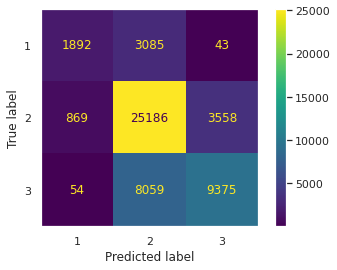

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

As we can see, the confusion matrix is quite similar (in proportion) to the best baseline model's one. They more or less fail in the same predictions and hit the same ones.

##### Submission
Now, let's prepare the submission and check the final results with the platform scorage.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-10 13:01:46--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-10 13:01:46--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  35.8MB/s    in 0.2s    

2022-12-10 13:01:49 (35.8 MB/s) - ‘test_values.csv’ saved [7815385/7815

In [ ]:
predictions = model.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_xg = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_xg.head()

--2022-12-10 13:01:54--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-10 13:01:55--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.01s   

2022-12-10 13:01:55 (50.2 MB/s) - ‘submission_fo

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission_xg.to_csv('submission_xg.csv')

The obtained score was $F_{micro} = 0.6990$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_xgboost.csv` section.

#### StackingClassifier
After trying with the tree based ensembling models and, in order to deal with the implementation problem of ensembling several kNN as base estimators, the teacher proposed us to try with some ensembling algorithms. One of them was the StackingClassifier.

It works similarly to the tree based ones:
1. It works at two leves (at least the basic implementation). In the first level, we can find the weak learners giving their prediction. And in the second level, they need an stronger learner to compose up the final decission.
References: 
2. In this case, we can _stack_ several weak learners of different types, i.e., we can have different algorithms per each base learner.

For further details about the implementation in Scikit Learn and the main concepts, here we indicate the used references.
1. [Stacking made easy with Sklearn](https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b)
2. [Stacking Ensemble Machine Learning with Python](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)
3. [LogisticRegression docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
4. [StackingClassifier docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

Once we have imported the relevant libraries, we can go to the implementation of the algorithm. We have decided to combine our two best baseline models. Checking the Section 3, the best models (according to their f1 score) where:
- kNN (2nd iteration)
- Decission Trees (2nd iteration)

As the meta learner (the one composing the final decision) we will use the LogisticRegression, since we are in a classifying task.

In [ ]:
# General algorithm for Stacking Classifier [Ref. 1]

# choose base learners (with bruteforced hyperparametrization <Section 3>)
base_learners = [
    ('knn', KNeighborsClassifier(n_neighbors=16, weights='uniform', metric='minkowski', p=1)), # Section 3: kNN (2nd iteration)
    ('dt', DecisionTreeClassifier(criterion='entropy', max_depth = 23, class_weight='balanced')) # Section 3: (2nd iteration)
]

# choose meta learner (classification --> Logistic Regression) [Ref. 2 & 3]
meta_learner = LogisticRegression(random_state=90, n_jobs=-1)

# prepare cross validation parameter
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)

# initialize Stacking Classifier with the meta-learner [Ref. 4]
stk_model = StackingClassifier(
    estimators = base_learners,
    final_estimator = meta_learner,
    cv = kfold,
    n_jobs = -1)

# Fit the model
%time stk_model.fit(x_train, y_train) 

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 245 ms, sys: 190 ms, total: 435 ms
Wall time: 21 s


StackingClassifier(cv=StratifiedKFold(n_splits=10,
        random_state=RandomState(MT19937) at 0x7FD7C6236D40, shuffle=False),
                   estimators=[('knn',
                                KNeighborsClassifier(n_neighbors=16, p=1)),
                               ('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=23))],
                   final_estimator=LogisticRegression(n_jobs=-1,
                                                      random_state=90),
                   n_jobs=-1)

Let's now analyse its performance with the F1 Score, since its our reference scorage.

In [ ]:
from sklearn.metrics import f1_score
# final model assessment
pred_test = stk_model.predict(x_test)
pred_train = stk_model.predict(x_train)

print(f'Train Accuracy: {f1_score(y_train, pred_train, average="micro")}' )
print(f'Test Accuracy: {f1_score(y_test, pred_test, average="micro")}' )

print('Classification Report:')
print(classification_report(y_test, pred_test))

Train Accuracy: 0.7749040675364544
Test Accuracy: 0.7211872373899196
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.45      0.54      5020
           2       0.73      0.83      0.78     29613
           3       0.72      0.61      0.66     17488

    accuracy                           0.72     52121
   macro avg       0.71      0.63      0.66     52121
weighted avg       0.72      0.72      0.71     52121



Fortunately, it improves the accuracy, with a $72.11%$ of accuracy.

##### Visualization
We consider interesing to check and analyse a bit the confussion matrix and understand where it fails/hits.

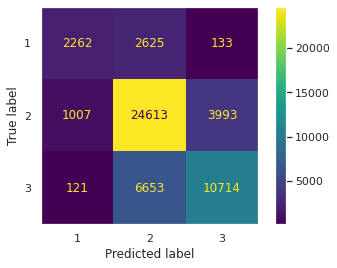

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stk_model.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

Again, it is quite similar to the confussion matrix of the baseline models. And make sense, since we are using two of our baseline models, so the fails should be more or less according to those.

##### Submission
Now, let's prepare the submission and check the final results with the platform scorage.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-09 12:55:12--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-09 12:55:12--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  --.-KB/s    in 0.02s   

2022-12-09 12:55:12 (311 MB/s) - ‘test_values.csv’ saved [7815385/78153

In [ ]:
predictions = stk_model.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_stk = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_stk.head()

--2022-12-09 12:55:14--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-09 12:55:14--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.005s  

2022-12-09 12:55:14 (143 MB/s) - ‘submission_for

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,2


In [ ]:
my_submission_stk.to_csv('submission_stk.csv')

The obtained score was $F_{micro} = 0.7166$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_stk.csv` section.

#### VotingClassifier

Our final ensembler model will be VotingClassifier as it was suggested by the professor.

This ensemble model trains several other base models or estimators, typically simpler ones, in order to aggregate their results into a final result. This aggregation is done by voting, following two different criteria:

- Hard: Voting is calculated on the predicted output class.
- Soft: Voting is calculated on the predicted probability of the output class.

This model is specially powerful because it has the capability of solving errors present on individual models.

For further details about the main concepts, here we indicate the used references.

- [Use Voting Classifier to improve the performance of your ML model](https://towardsdatascience.com/use-voting-classifier-to-improve-the-performance-of-your-ml-model-805345f9de0e)

We are going to use our last iteration's classifiers in order to compose this VotingClassifier, which are kNN, Decision Trees and StackingClassifier.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

For the VotingClassifier, we need to construct the baseline models.

In [ ]:
# Base models

# kNN
n_neighbors = 16
weights = 'uniform'
knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric='minkowski', p=1) 

# Decision Tree Classifier
d_tree = DecisionTreeClassifier(criterion='entropy', max_depth = 23, class_weight='balanced')

In [ ]:
# Stacking Classifier

# choose base learners (with bruteforced hyperparametrization <Section 3>)
base_learners = [
    ('knn', KNeighborsClassifier(n_neighbors=16, weights='uniform', metric='minkowski', p=1)), # Section 3: kNN (2nd iteration)
    ('dt', DecisionTreeClassifier(criterion='entropy', max_depth = 23, class_weight='balanced')) # Section 3: (2nd iteration)
]

# choose meta learner (classification --> Logistic Regression) [Ref. 2 & 3]
meta_learner = LogisticRegression(random_state=90, n_jobs=-1)

# prepare cross validation parameter
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)

# initialize Stacking Classifier with the meta-learner [Ref. 4]
stk_model = StackingClassifier(
    estimators = base_learners,
    final_estimator = meta_learner,
    cv = kfold,
    n_jobs = -1)

And with all three classifiers, we can now construct the Voting Classifier.

In [ ]:
vote = VotingClassifier(estimators=[('knn', knn), ('dtree', d_tree), ('stk', stk_model)], voting='hard')
vote = vote.fit(x_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


And now, let's analyse its performance with the F1 Score.

In [ ]:
from sklearn.metrics import f1_score
# final model assessment
pred_test = vote.predict(x_test)
pred_train = vote.predict(x_train)

print(f'Train Accuracy: {f1_score(y_train, pred_train, average="micro")}' )
print(f'Test Accuracy: {f1_score(y_test, pred_test, average="micro")}' )

print('Classification Report:')
print(classification_report(y_test, pred_test))

Train Accuracy: 0.7761895625479662
Test Accuracy: 0.7197674641699123
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.49      0.54      5020
           2       0.73      0.82      0.77     29613
           3       0.72      0.61      0.66     17488

    accuracy                           0.72     52121
   macro avg       0.69      0.64      0.66     52121
weighted avg       0.72      0.72      0.71     52121



##### Visualization
We consider interesing to check and analyse a bit the confussion matrix and understand where it fails/hits.

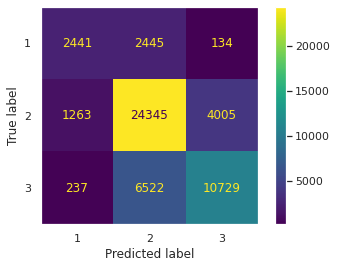

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vote.classes_)
disp.plot()
plt.grid(False)
disp.figure_.savefig("confussion_matrix.pdf")
plt.show()

The results are identical to the StackingClassifier. It is slightly less biased into the second label, but it is not a significant ammount.

##### Submission
Now, let's prepare the submission and check the final results with the platform scorage.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-15 00:55:52--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-15 00:55:52--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  --.-KB/s    in 0.03s   

2022-12-15 00:55:52 (214 MB/s) - ‘test_values.csv’ saved [7815385/78153

In [ ]:
predictions = vote.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_vote = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_vote.head()

--2022-12-15 00:56:01--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-15 00:56:02--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.02s   

2022-12-15 00:56:02 (47.1 MB/s) - ‘submission_fo

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,2


In [ ]:
my_submission_vote.to_csv('submission_vote.csv')

The obtained score was $F_{micro} = 0.7144$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_vote.csv` section.

### Hyperparametrization
The only step left is trying to improve the results based on the ensemble models by using hyperparametrization techniques.

We will use the XgBoost model from the previous section to work with.

#### XgBoost & RandomizedSearchCV
First, let's try with the Randomized Seach Cross Validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import time
from xgboost import XGBClassifier

In [ ]:
# create a default XGBoost classifier
model = XGBClassifier(tree_method = "gpu_hist", random_state=54)

# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)# fit grid search
%time best_model = grid.fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 15.6 s, sys: 1.61 s, total: 17.2 s
Wall time: 34min


Once the model is created, let's get its accuracy.

In [ ]:
from sklearn.metrics import f1_score
# final model assessment
pred_test = best_model.predict(x_test)
pred_train = best_model.predict(x_train)

print(f'Train Accuracy: {f1_score(y_train, pred_train, average="micro")}' )
print(f'Test Accuracy: {f1_score(y_test, pred_test, average="micro")}' )

print('Classification Report:')
print(classification_report(y_test, pred_test))

Train Accuracy: 0.7019234458940906
Test Accuracy: 0.6983365629976401
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.37      0.48      5020
           2       0.69      0.85      0.76     29613
           3       0.72      0.53      0.61     17488

    accuracy                           0.70     52121
   macro avg       0.70      0.59      0.62     52121
weighted avg       0.70      0.70      0.69     52121



##### Submision

The final step is to upload the results to the Driven Data platform.

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-09 09:57:47--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-09 09:57:47--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  --.-KB/s    in 0.06s   

2022-12-09 09:57:48 (130 MB/s) - ‘test_values.csv’ saved [7815385/7

In [ ]:
print(x_train.columns)
print(test_values_subset.columns)

Index(['geo_level_1_id', 'geo_level_2_id',
       'has_superstructure_mud_mortar_stone', 'age', 'geo_level_3_id',
       'foundation_type_h', 'foundation_type_i', 'foundation_type_r',
       'foundation_type_u', 'foundation_type_w'],
      dtype='object')
Index(['geo_level_1_id', 'geo_level_2_id',
       'has_superstructure_mud_mortar_stone', 'age', 'geo_level_3_id',
       'foundation_type_h', 'foundation_type_i', 'foundation_type_r',
       'foundation_type_u', 'foundation_type_w'],
      dtype='object')


In [ ]:
predictions = best_model.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_xgboost_rscv = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_xgboost_rscv.head()

--2022-12-09 09:59:20--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-09 09:59:21--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv.1’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.03s   

2022-12-09 09:59:21 (27.1 MB/s) - ‘submiss

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission_xgboost_rscv.to_csv('submission_xg_rscv.csv')

The obtained score was $F_{micro} = 0.6987$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_xg_rscv.csv` section.

#### XgBoost & GridSearchCV
Now, in order to try with both algorithms studied in class, we will try in this ocassion with the GridSearch hyperparametrization algorithm.

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
from xgboost import XGBClassifier

In [ ]:
# create a default XGBoost classifier
xgb_model = XGBClassifier(tree_method = "gpu_hist", random_state=212)

# Create the grid search parameter grid and scoring functions
param_dist = {"n_estimators": [32, 64, 128], # Number of trees in random forest
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [8,4, 2], # Maximum number of levels in tree
              "min_samples_split": [2, 4, 6], #  Minimum number of samples required to split a node
              "min_samples_leaf": [8, 12, 16], # Minimum number of samples required at each leaf node
              "bootstrap": [True, False] # Method of selecting samples for training each tree
            }

# create the grid search object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)
n_iter = 50
grid_class = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_dist,
    cv = kfold,
    n_jobs = -1)

# Fit the random search model with the grid search
%time best_model_grid = grid_class.fit(X = x_train, y = y_train)

As always, let's check it accuracy based on the f1 score.

In [ ]:
from sklearn.metrics import f1_score
# final model assessment
pred_test = best_model_grid.predict(x_test)
pred_train = best_model_grid.predict(x_train)

print(f'Train Accuracy: {f1_score(y_train, pred_train, average="micro")}' )
print(f'Test Accuracy: {f1_score(y_test, pred_test, average="micro")}' )

print('Classification Report:')
print(classification_report(y_test, pred_test))

###### Submision

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')
test_values_subset = test_values[selected]
test_values_subset = pd.get_dummies(test_values_subset)

--2022-12-09 09:57:47--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-09 09:57:47--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  --.-KB/s    in 0.06s   

2022-12-09 09:57:48 (130 MB/s) - ‘test_values.csv’ saved [7815385/7

In [ ]:
predictions = best_model_grid.predict(test_values_subset)

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission_xgboost_gscv = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission_xgboost_gscv.head()

--2022-12-09 09:59:20--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv [following]
--2022-12-09 09:59:21--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/submission_format.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777012 (759K) [text/plain]
Saving to: ‘submission_format.csv.1’

submission_format.c 100%[===================>] 758.80K  --.-KB/s    in 0.03s   

2022-12-09 09:59:21 (27.1 MB/s) - ‘submiss

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
my_submission_xgboost_gscv.to_csv('submission_xg_gscv.csv')

The obtained score was $F_{micro} = 0.7213$ for more information about the submission, you can check the submission page on the [GitHub repository](https://github.com/SergioJF10/MLT-ESI-UCLM_CIS/tree/main/ritcher/Submissions) `submission_xb_gscv.csv` section.

Which means that actually, is the best, and so, the **final model** for predicting the `damage_grade` for a given building.